<a href="https://colab.research.google.com/github/chulgit/hello-world/blob/master/Blog_7_Modeling_with_Candlestick_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 저는 Colab에서 진행하고, 구글 드라이브에 저장되어 있는 데이터를 이용했기 때문에 
# 이런식으로 데이터를 불러왔습니다.
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive/My Drive/data

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).
/gdrive/My Drive/data


### 1. 캔들스틱 차트 그리기

In [ ]:
# 캔들스틱 차트를 그리기 위해서 mpl_finance 이용합니다.
pip install mpl_finance

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from shutil import copyfile, move
from mpl_finance import candlestick2_ochl

In [ ]:
def ohlc2cs(fname, seq_len, dimension):
    # python preprocess.py -m ohlc2cs -l 20 -i stockdatas/EWT_testing.csv -t testing
    print("Converting olhc to candlestick")
    symbol = fname.split('_')[0]
    print(symbol)
    df = pd.read_csv(fname, names=['Open','High','Low','Close','Volume','Change'])
    df.fillna(0)
    plt.style.use('dark_background')
    df.reset_index(inplace=True)

    figs = np.zeros((len(df)-1, dimension, dimension, 3))
    labels = []
    for i in range(0, len(df)-1):
        # ohlc+volume
        c = df.ix[i:i + int(seq_len) - 1, :]
        c_ = df.ix[i:i + int(seq_len), :]
        if len(c) == int(seq_len):
            my_dpi = 96
            fig = plt.figure(figsize=(dimension / my_dpi,
                                      dimension / my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            candlestick2_ochl(ax1, c['Open'], c['Close'], c['High'],
                              c['Low'], width=1,
                              colorup='#77d879', colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')

            # create the second axis for the volume bar-plot
            # Add a seconds axis for the volume overlay
          
        starting = c_["Close"].iloc[-2]
        endvalue = c_["Close"].iloc[-1]
        if endvalue > starting :
            label = 1
        else :
            label = 0
        labels.append(label)

        fig.canvas.draw()
        fig_np = np.array(fig.canvas.renderer._renderer)
        figs[i] = fig_np[:,:,:3]

        plt.close(fig)
        # normal length - end

    print("Converting olhc to candlestik finished.")
    return figs, labels

In [ ]:
# 036570 : 엔씨소프트
inputs = '036570_from_2010.csv'
seq_len = 20
dimension = 48

figures, labels = ohlc2cs(inputs, seq_len, dimension)

Converting olhc to candlestick
036570


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


Converting olhc to candlestik finished.


In [ ]:
#위 함수로 생성된 figures는 값의 범위가 0~255 이기 때문에 0~1로 맞춰주기 위해 255로 나눕니다.
figures = figures/255.0
print(np.shape(labels), np.shape(figures))

(2219,) (2219, 48, 48, 3)


### 2. 데이터 Generator 생성

In [ ]:
def single_stock_generator(chart, labels, batch_size) :
    #output [chart, labels]
    while True :
        stock_batch = np.zeros(shape=(batch_size, dimension, dimension, 3))
        label_batch = np.zeros(shape=(batch_size, ))
        for i in range(batch_size) :
            idx = np.random.randint(len(labels))
            stock_batch[i] = chart[idx]
            label_batch[i] = labels[idx]

        yield stock_batch, label_batch


In [ ]:
train_len = 1500
batch_size = 16
train_gen = single_stock_generator(figures[:train_len], labels[:train_len], batch_size)
test_gen = single_stock_generator(figures[train_len:], labels[train_len:], batch_size)


In [ ]:
tmp_data = next(train_gen)
print("Chart image shape : ",np.shape(tmp_data[0]))
print("Label shape :",np.shape(tmp_data[1]))

Chart image shape :  (16, 48, 48, 3)
Label shape : (16,)


In [ ]:
# 만들어진 차트 이미지 중 하나를 예시로 그려보겠습니다.
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline

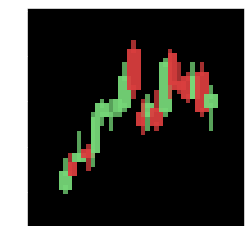

In [ ]:
plt.figure()
plt.imshow(tmp_data[0][0][:,:,:])
plt.show()

### 3. 모델 작성

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1
import tensorflow as tf

In [ ]:
# Keras의 Functional APi를 이용할 거라서 불러와줍니다.
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# 첫번째 시도할 구조는 논문에서 제시한 CNN 구조
# CNN의 filter size, dropout rate, padding 등은 언급이 안되어 있어서 임의로 넣음

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(48, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(96, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 24, 24, 48)        13872     
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 12, 12, 48)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 12, 12, 64)        277

In [ ]:
num_iters = train_len // batch_size
num_epochs = 10

In [ ]:
def train_step(train_data_gen, test_data_gen, model) :
    optimizer = tf.keras.optimizers.Adam(0.0001)
    model = model
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    num_test_iters = num_iters // 4
    for epoch in range(num_epochs) :
        epoch_loss_avg = tf.keras.metrics.Mean()
        val_loss_avg = tf.keras.metrics.Mean()

        for iter in range(num_iters) :
            x_batch, y_batch = next(train_data_gen)
            with tf.GradientTape() as tape :
                y_ = model(x_batch)
                loss_value = loss_fn(y_batch, y_)
                grads = tape.gradient(loss_value, model.trainable_variables)            
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss_avg(loss_value)
        
        for iter in range(num_test_iters) :
            x_batch, y_batch = next(test_data_gen)
            y_ = model(x_batch)
            loss_value = loss_fn(y_batch, y_)
            val_loss_avg(loss_value)
        

        
        print("Epoch {:03d}: , Train Loss: {:.5f}".format(epoch, epoch_loss_avg.result()))
        print("Val_Loss: {:.3f}".format(val_loss_avg.result()))


In [ ]:
train_step(train_gen, test_gen, model)

Epoch 000: , Train Loss: 0.69078
Val_Loss: 0.697
Epoch 001: , Train Loss: 0.69190
Val_Loss: 0.701
Epoch 002: , Train Loss: 0.69189
Val_Loss: 0.693
Epoch 003: , Train Loss: 0.69279
Val_Loss: 0.693
Epoch 004: , Train Loss: 0.69222
Val_Loss: 0.696
Epoch 005: , Train Loss: 0.69333
Val_Loss: 0.695
Epoch 006: , Train Loss: 0.69185
Val_Loss: 0.699
Epoch 007: , Train Loss: 0.69222
Val_Loss: 0.693
Epoch 008: , Train Loss: 0.69112
Val_Loss: 0.696
Epoch 009: , Train Loss: 0.69273
Val_Loss: 0.691


In [ ]:
y_

<tf.Tensor: id=5683842, shape=(2219, 1), dtype=float32, numpy=
array([[0.4786848 ],
       [0.47747847],
       [0.4801753 ],
       ...,
       [0.47713557],
       [0.47713557],
       [0.47713557]], dtype=float32)>

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(48, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(96, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 24, 24, 48)        13872     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 12, 12, 48)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 12, 12, 64)        27712     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 6, 6, 64)          0  

In [ ]:
train_step(train_gen, test_gen, model)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: , Train Loss: 0.69291
Val_Loss: 0.692
Epoch 001: , Train Loss: 0.69183
Val_Loss: 0.698
Epoch 002: , Train Loss: 0.68997
Val_Loss: 0.710
Epoch 003: , Train Loss: 0.69299
Val_Loss: 0.699
Epoch 004: , Train Loss: 0.69032
Val_Loss: 0.692
Epoch 005: , Train Loss: 0.69190
Val_Loss: 0.693
Epoch 006: , Train Loss: 0.69220
Val_Loss: 0.696
Epoch 007: , Train Loss: 0.69304
Val_Loss: 0.693
Epoch 008: , Train Loss: 0.69274
Val_Loss: 0.696
Epoch 009: , Train Loss: 0.69194
Val_Loss: 0.691


In [ ]:
y_

<tf.Tensor: id=5683842, shape=(2219, 1), dtype=float32, numpy=
array([[0.4786848 ],
       [0.47747847],
       [0.4801753 ],
       ...,
       [0.47713557],
       [0.47713557],
       [0.47713557]], dtype=float32)>

In [ ]:
inputs = keras.Input(shape=(48, 48, 3))
x = inputs
x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(32, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(64, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(128, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(256, 3, activation='relu', padding="same")(x)
x = layers.Conv2D(256, 3, activation='relu', padding="same")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Flatten()(x)
x = layers.Dense(1, activation='sigmoid')(x)
outputs = x

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 12, 12, 64)        0  

In [ ]:
train_step(train_gen, test_gen, model)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: , Train Loss: 0.69313
Val_Loss: 0.694
Epoch 001: , Train Loss: 0.68940
Val_Loss: 0.695
Epoch 002: , Train Loss: 0.69376
Val_Loss: 0.698
Epoch 003: , Train Loss: 0.69253
Val_Loss: 0.695
Epoch 004: , Train Loss: 0.69272
Val_Loss: 0.704
Epoch 005: , Train Loss: 0.69105
Val_Loss: 0.700
Epoch 006: , Train Loss: 0.69040
Val_Loss: 0.700
Epoch 007: , Train Loss: 0.69344
Val_Loss: 0.694
Epoch 008: , Train Loss: 0.69110
Val_Loss: 0.697
Epoch 009: , Train Loss: 0.69054
Val_Loss: 0.699
Epoch 010: , Train

In [ ]:
y_ = model(x_batch)
y_

<tf.Tensor: id=4077524, shape=(2219, 1), dtype=float32, numpy=
array([[0.47132692],
       [0.47132692],
       [0.47132692],
       ...,
       [0.4713269 ],
       [0.4713269 ],
       [0.4713269 ]], dtype=float32)>